In [1]:
import tensorflow.keras as keras
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

Using TensorFlow backend.


(393732, 7)
88751


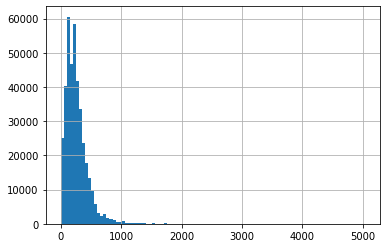

In [2]:
df = pd.read_csv('2018-06-06-ss.cleaned.csv')
df.len.hist(bins=100)
print(df.shape)

def seq2ngrams(seqs, n=3):
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])

maxlen_seq = 128
input_seqs, target_seqs = df[['seq', 'sst3']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
input_grams = seq2ngrams(input_seqs)
print(len(input_seqs))

In [3]:
tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(input_grams)
input_data = tokenizer_encoder.texts_to_sequences(input_grams)
input_data = sequence.pad_sequences(input_data, maxlen=maxlen_seq, padding='post')

tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
target_data = sequence.pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
target_data = to_categorical(target_data)
input_data.shape, target_data.shape

((88751, 128), (88751, 128, 4))

In [11]:
from keras.layers import Embedding, Dense, TimeDistributed, Bidirectional, LSTM
from keras.models import Sequential

In [12]:
n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq))
model.add(Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(n_tags, input_dim=4, activation="softmax")))
model.summary()

8421 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 128, 128)          1077888   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 128)          98816     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 128, 4)            516       
Total params: 1,177,220
Trainable params: 1,177,220
Non-trainable params: 0
_________________________________________________________________


In [13]:
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf

def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc])
history = model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_test, y_test), verbose=1)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Train on 53250 samples, validate on 35501 samples
Epoch 1/20
53250/53250 [==============================] - 627s 12ms/step - loss: 0.4123 - acc: 0.8262 - q3_acc: 0.7247 - val_loss: 0.3240 - val_acc: 0.8687 - val_q3_acc: 0.7919
Epoch 2/20
53250/53250 [==============================] - 673s 13ms/step - loss: 0.2867 - acc: 0.8865 - q3_acc: 0.8191 - val_loss: 0.3049 - val_acc: 0.8792 - val_q3_acc: 0.8086
Epoch 3/20
53250/53250 [==============================] - 691s 13ms/step - loss: 0.2548 - acc: 0.8999 - q3_acc: 0.8405 - val_loss: 0.2701 - val_acc: 0.8958 - val_q3_acc: 0.8349
Epoch 4/20
53250/53250 [==============================] - 681s 13ms/step - loss: 0.2327 - acc: 0.9090 - q3_acc: 0.8549 - val_loss: 0.2434 - val_acc: 0.9069 - val_q3_acc: 0.8524
Epoch 5/20
53250/53250 [==============================] - 729s 14ms/step - loss: 0.2149 - acc: 0.9163 - q3_acc: 0.8665 - val_loss: 0.2234 - val_acc: 0.9147 - val_q3_acc: 0.8647
Epoch 6/20
53250/53250 [==============================] - 761s 14

KeyboardInterrupt: 